In [1]:
import gensim
from gensim import utils
import numpy as np
import sys
from nltk import word_tokenize
from nltk import download
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
%matplotlib inline

In [2]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [3]:
download('punkt') #tokenizer, run once
download('stopwords') #stopwords dictionary, run once
stop_words = stopwords.words('english')

def preprocess(text):
    text = str(text)
    text = text.lower()
    text = text.replace("+"," ")
    doc = word_tokenize(text)
    doc = [word for word in doc if word.isalpha()]
    doc = [word for word in doc if word in model.vocab]
    return doc

[nltk_data] Downloading package punkt to /home/khoa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/khoa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df_train_link = './NLP_data/phrase_pair_remove_trivial_match_train.csv'
df_val_link = './NLP_data/phrase_pair_remove_trivial_match_val.csv'
df_test_link = './NLP_data/phrase_pair_remove_trivial_match_test.csv'

In [5]:
df_train = pd.read_csv(df_train_link)
df_val = pd.read_csv(df_val_link)
df_test = pd.read_csv(df_test_link)

Working on Validation DataFrame

In [6]:
wdf = df_train[["phrase1","phrase2","ytrue"]]
wdf.columns.astype(str)

Index(['phrase1', 'phrase2', 'ytrue'], dtype='object')

In [7]:
wdf.head()

,phrase1,phrase2,ytrue
0,man,hard+hat,False
1,man,caution+vest,False
2,man,street,False
3,man,orange+flag,False
4,blue+hard+hat,man,False


In [8]:
def list2vec(l):
    if len(l)==0:
        nanvec = np.empty((300,), float)
        nanvec.fill(np.nan)
        return nanvec
    nl = [model[w] if w in model.vocab else np.nan for w in l]
    return np.nanmean(nl,axis=0)

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
sim = []
for idx in range(len(wdf.phrase1)):
    v1 = list2vec(preprocess(wdf.phrase1[idx])).reshape(1, -1)
    v2 = list2vec(preprocess(wdf.phrase2[idx])).reshape(1, -1)
    if((np.isnan(v1[0][0]))|(np.isnan(v2[0][0]))):
        sim.append(0)
    else:
        sim.append(cosine_similarity(v1,v2).item(0))

In [11]:
wdf["sim"]=sim

/home/khoa/anaconda3/envs/ids/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score

In [13]:
prec, rec, thresh = precision_recall_curve(wdf.ytrue, wdf.sim)
f1 = 2 * (prec * rec) / (prec + rec)
best_idx = np.nanargmax(f1)
best_thresh = thresh[best_idx]
print('best f1: %.2f prec: %.2f rec: %.2f' % (f1[best_idx] * 100, prec[best_idx] * 100, rec[best_idx] * 100))

best f1: 65.32 prec: 60.53 rec: 70.93


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

(0.0, 1.0)

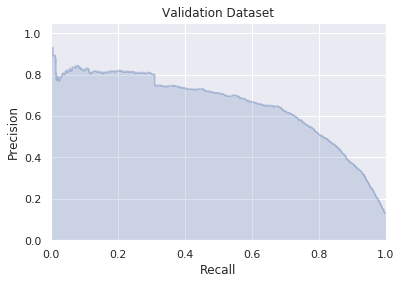

In [24]:
plt.step(rec, prec, color='b', alpha=0.2,
         where='post')
plt.fill_between(rec, prec, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Validation Dataset')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

Working on test data

In [16]:
wdf = df_test[["phrase1","phrase2","ytrue"]]
wdf.columns.astype(str)

Index(['phrase1', 'phrase2', 'ytrue'], dtype='object')

In [17]:
wdf.head()

,phrase1,phrase2,ytrue
0,several+climbers,seven+climbers,True
1,several+climbers,rock+face,False
2,several+climbers,another+man,False
3,several+climbers,rope,False
4,rock,seven+climbers,False


In [18]:
sim = []
for idx in range(len(wdf.phrase1)):
    v1 = list2vec(preprocess(wdf.phrase1[idx])).reshape(1, -1)
    v2 = list2vec(preprocess(wdf.phrase2[idx])).reshape(1, -1)
    if((np.isnan(v1[0][0]))|(np.isnan(v2[0][0]))):
        sim.append(0)
    else:
        sim.append(cosine_similarity(v1,v2).item(0))

In [19]:
wdf["sim"] = sim

/home/khoa/anaconda3/envs/ids/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
wdf.head()

,phrase1,phrase2,ytrue,sim
0,several+climbers,seven+climbers,True,0.919587
1,several+climbers,rock+face,False,0.215778
2,several+climbers,another+man,False,0.187044
3,several+climbers,rope,False,0.316738
4,rock,seven+climbers,False,0.260135


In [21]:
pred = wdf.sim > best_thresh
prec = precision_score(wdf.ytrue, pred)
rec = recall_score(wdf.ytrue, pred)
f1 = f1_score(wdf.ytrue, pred)
print('f1: %.2f prec: %.2f rec: %.2f' % (f1 * 100, prec * 100, rec * 100))

f1: 66.00 prec: 61.47 rec: 71.25


(0.0, 1.0)

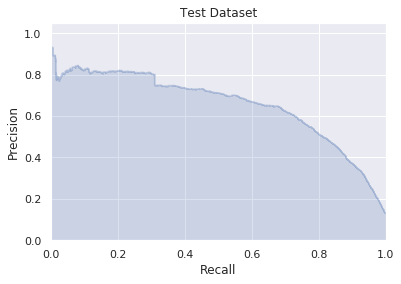

In [22]:
prec, rec, thresh = precision_recall_curve(wdf.ytrue, wdf.sim)
plt.step(rec, prec, color='b', alpha=0.2,
         where='post')
plt.fill_between(rec, prec, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Test Dataset')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

In [23]:
best_thresh

0.49387103319168091